## Import libraries

In [306]:
import os
import math
import json
import folium
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from scipy import stats
import networkx as nx
from networkx import average_clustering, number_of_nodes, number_of_edges, erdos_renyi_graph
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy import cos, sin, arcsin, sqrt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import InterclusterDistance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from geopy.geocoders import Nominatim
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.figure(figsize=(20,5))

PALETTE_DEG = ["FF"]
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]

R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12

<Figure size 1440x360 with 0 Axes>

In [248]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
df['delta'] = (df.delivery_dt - df.delivery_effective).dt.total_seconds() / 3600

## Utils functions

In [249]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if diff:
    return pd.DataFrame.from_dict(differences)
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def remove_outlayers(dataframe: pd.DataFrame, feature: str, complete=False):
  z_scores = stats.zscore(dataframe[feature])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = abs_z_scores < 3
  if complete:
    return dataframe[filtered_entries]
  return dataframe[ filtered_entries ][feature]


## Analisis de redes sociales: 

### Preprocessing

In [250]:
#NODO -> PICKUP_COMUNA or DROPOFF_COMUNA
#EDGE -> ENVIA PEDIDO DE // RECIBE PEDIDO DE
#DIRECTED GRAPH
#WEIGHT -> AMOUNT OF DELIVERIES

In [251]:
dfLocation = df[['id', 'pickup_location', 'delivery_location', 'distance']].copy()

In [252]:
def getComunaOrAddress(addressObjStr):
    address = json.loads(addressObjStr)['address']
    addressList = address.split(',')
    selectedAddress = addressList[1].strip().lower() if len(addressList) >= 2 else address.strip().lower()
    selectedAddress = selectedAddress if selectedAddress != 'penalolen' else "peñalolén"
    return selectedAddress

In [253]:
dfLocation['pickup_address'] = dfLocation['pickup_location'].apply(getComunaOrAddress)
dfLocation['delivery_address'] = dfLocation['delivery_location'].apply(getComunaOrAddress)

In [254]:
dfLocation

,id,pickup_location,delivery_location,distance,pickup_address,delivery_address
0,t-expspa-41,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.4746198,""lng"":-70.5664998,""instruct...",4.700000,la reina,peñalolén
1,t-expspa-25,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.554590999,""lng"":-70.6056534,""instru...",14.500000,la reina,la florida
2,t-expspa-46,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.351806599,""lng"":-70.666318199,""inst...",15.000000,la reina,huechuraba
4,t-expspa-29,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.450334499,""lng"":-70.7629295,""instru...",19.700001,la reina,pudahuel
5,t-expspa-23,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.4504296,""lng"":-70.7627742,""instruct...",19.900000,la reina,pudahuel
...,...,...,...,...,...,...
251818,t-festda-117,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.523260199,""lng"":-70.6537183,""instru...",16.100000,las condes,la cisterna
251819,t-festda-97,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.4871977,""lng"":-70.604682099,""instru...",9.700000,las condes,macul
251820,t-festda-88,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.4893959,""lng"":-70.592562,""instructi...",10.000000,las condes,macul
251821,t-festda-195,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.594700699,""lng"":-70.5744201,""instru...",22.400000,las condes,puente alto


In [255]:
scopeComuna = ["Vitacura", "Santiago", "San Ramón", "San Miguel", "San Joaquín", "Renca", "Recoleta", "Quinta Normal", "Quilicura", "Pudahuel", "Providencia", "Peñalolén", "Pedro Aguirre Cerda", "Ñuñoa", "Maipú", "Macul", "Lo Prado", "Lo Espejo", "Lo Barnechea", "Las Condes", "La Reina", "La Pintana", "La Granja", "La Florida", "La Cisterna", "Independencia", "Huechuraba", "Estación Central", "El Bosque", "Conchalí", "Cerro Navia", "Cerrillos"]
scopeComuna = [e.lower() for e in scopeComuna]

In [256]:
dfLocation = dfLocation[(dfLocation['pickup_address'].isin(scopeComuna) & dfLocation['delivery_address'].isin(scopeComuna))]

In [257]:
dfLocation

,id,pickup_location,delivery_location,distance,pickup_address,delivery_address
0,t-expspa-41,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.4746198,""lng"":-70.5664998,""instruct...",4.700000,la reina,peñalolén
1,t-expspa-25,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.554590999,""lng"":-70.6056534,""instru...",14.500000,la reina,la florida
2,t-expspa-46,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.351806599,""lng"":-70.666318199,""inst...",15.000000,la reina,huechuraba
4,t-expspa-29,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.450334499,""lng"":-70.7629295,""instru...",19.700001,la reina,pudahuel
5,t-expspa-23,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.4504296,""lng"":-70.7627742,""instruct...",19.900000,la reina,pudahuel
...,...,...,...,...,...,...
251817,t-festda-99,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.440227999,""lng"":-70.609772,""instruc...",4.700000,las condes,providencia
251818,t-festda-117,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.523260199,""lng"":-70.6537183,""instru...",16.100000,las condes,la cisterna
251819,t-festda-97,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.4871977,""lng"":-70.604682099,""instru...",9.700000,las condes,macul
251820,t-festda-88,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.4893959,""lng"":-70.592562,""instructi...",10.000000,las condes,macul


# For condensed graph. Start

In [120]:
dfLocation['deliveriesNo'] = dfLocation.groupby(['pickup_address', 'delivery_address'])['id'].transform('count')

In [123]:
dfLocation

,id,pickup_location,delivery_location,pickup_address,delivery_address,deliveriesNo
0,t-expspa-41,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.4746198,""lng"":-70.5664998,""instruct...",la reina,peñalolén,45
1,t-expspa-25,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.554590999,""lng"":-70.6056534,""instru...",la reina,la florida,48
2,t-expspa-46,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.351806599,""lng"":-70.666318199,""inst...",la reina,huechuraba,21
4,t-expspa-29,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.450334499,""lng"":-70.7629295,""instru...",la reina,pudahuel,12
5,t-expspa-23,"{""lat"":-33.438249999,""lng"":-70.57113,""instruct...","{""lat"":-33.4504296,""lng"":-70.7627742,""instruct...",la reina,pudahuel,12
...,...,...,...,...,...,...
251817,t-festda-99,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.440227999,""lng"":-70.609772,""instruc...",las condes,providencia,421
251818,t-festda-117,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.523260199,""lng"":-70.6537183,""instru...",las condes,la cisterna,83
251819,t-festda-97,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.4871977,""lng"":-70.604682099,""instru...",las condes,macul,126
251820,t-festda-88,"{""lat"":-33.4111751,""lng"":-70.6022845,""instruct...","{""lat"":-33.4893959,""lng"":-70.592562,""instructi...",las condes,macul,126


In [137]:
dfLocationUniques = dfLocation.drop_duplicates(subset=['pickup_address', 'delivery_address'], keep='last')

In [151]:
dfLocationUniques[['pickup_address', 'delivery_address', 'deliveriesNo']].to_csv('../data/deliveries_edges.csv', index=False, header=False)
dfLocationUniques.to_csv('../data/deliveries_nodes.csv', index=False)

# For condensed graph. End

# For normal graph. Start

In [258]:
dfLocation[['pickup_address', 'delivery_address', 'distance']].to_csv('../data/deliveries_edges.csv', index=False, header=False)

# For normal graph. End

### Creating graph

In [268]:
G = nx.read_edgelist('../data/deliveries_edges.csv', 
                     create_using=nx.DiGraph(), 
                     nodetype=str,
                     data=(("weight", float),), 
                     delimiter=",")

In [269]:
number_of_edges(G)

716

In [270]:
number_of_nodes(G)

32

In [271]:
list(Graph.edges(data=True))

[('la reina', 'peñalolén', {'weight': 6.900000095367432}),
 ('la reina', 'la florida', {'weight': 10.399999618530273}),
 ('la reina', 'huechuraba', {'weight': 12.300000190734863}),
 ('la reina', 'pudahuel', {'weight': 20.299999237060547}),
 ('la reina', 'providencia', {'weight': 7.0}),
 ('la reina', 'las condes', {'weight': 9.699999809265137}),
 ('la reina', 'lo barnechea', {'weight': 14.100000381469727}),
 ('la reina', 'ñuñoa', {'weight': 5.5}),
 ('la reina', 'santiago', {'weight': 0.0}),
 ('la reina', 'vitacura', {'weight': 9.699999809265137}),
 ('la reina', 'la reina', {'weight': 5.199999809265137}),
 ('la reina', 'san miguel', {'weight': 12.199999809265137}),
 ('la reina', 'pedro aguirre cerda', {'weight': 20.5}),
 ('la reina', 'la cisterna', {'weight': 16.600000381469727}),
 ('la reina', 'la granja', {'weight': 14.399999618530273}),
 ('la reina', 'renca', {'weight': 24.299999237060547}),
 ('la reina', 'quinta normal', {'weight': 18.299999237060547}),
 ('la reina', 'san ramón', {'w

In [272]:
average_clustering(G)

0.860915100694018

### Comparing with its equivalence random graph

In [226]:
nodesNo = number_of_nodes(G)
GProb = number_of_edges(G)/(nodesNo ** 2)
randomGraph = erdos_renyi_graph(n=nodesNo, p=GProb, seed=None, directed=True)
average_clustering(randomGraph)

0.6834021935786903

### G graph is cohesive because its average clustering coefficent is near to 1

## What are the 3 most important communes in terms of sending deliveries

In [284]:
importantPlaces = sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:3]
importantPlaces

[('pudahuel', 32), ('santiago', 31), ('recoleta', 31)]

In [285]:
importantPlacesDict = {'comuna': [e[0] for e in importantPlaces], 'outdegree': [e[1] for e in importantPlaces]}

In [286]:
importantPlacesDf =  pd.DataFrame(importantPlacesDict)
importantPlacesDf

,comuna,degree
0,pudahuel,32
1,santiago,31
2,recoleta,31


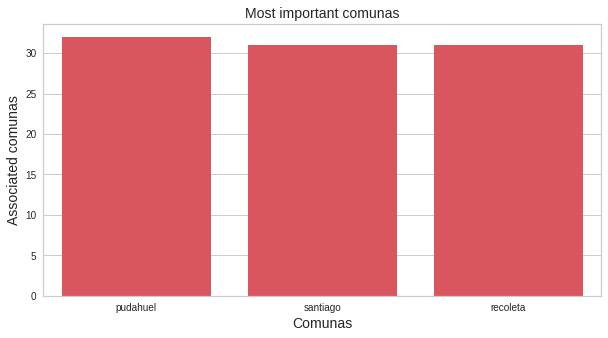

In [287]:
plt.figure(figsize=(10,5))
sns.barplot(x='comuna', y='outdegree', data=importantPlacesDf, color=PALETTE[1])
set_labels('Most important comunas', 'Comunas', 'Associated comunas')

#### Answer: The 'comuna' Pudahuel has sending deliveries to all of 32 'comunas' of Santiago (Including it self). "Santiago" and "Recoleta" has sending deliveries to 31 "comunas" (Including it self).

## What are the 3 most important communes in terms of receipt of shipments

In [296]:
importantPlaces = sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:3]

In [297]:
importantPlacesDict = {'comuna': [e[0] for e in importantPlaces], 'indegree': [e[1] for e in importantPlaces]}

In [298]:
importantPlacesDf =  pd.DataFrame(importantPlacesDict)
importantPlacesDf

,comuna,indegree
0,las condes,30
1,providencia,29
2,ñuñoa,28


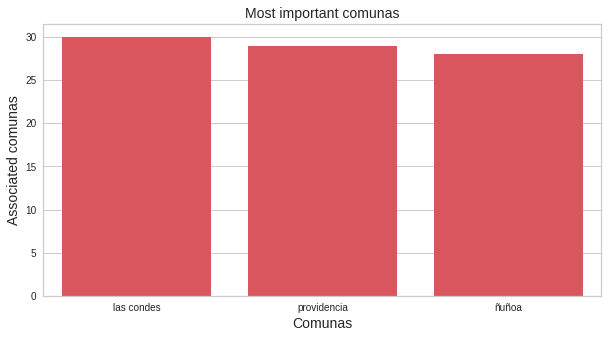

In [300]:
plt.figure(figsize=(10,5))
sns.barplot(x='comuna', y='indegree', data=importantPlacesDf, color=PALETTE[1])
set_labels('Most important comunas', 'Comunas', 'Associated comunas')

#### Answer: The 'comuna' Las Condes has received deliveries of 30 'comunas' of Santiago (Including it self). "Providencia" has received deliveries of 29 'comunas' and "ÑUÑOA" 28 (Including it self).

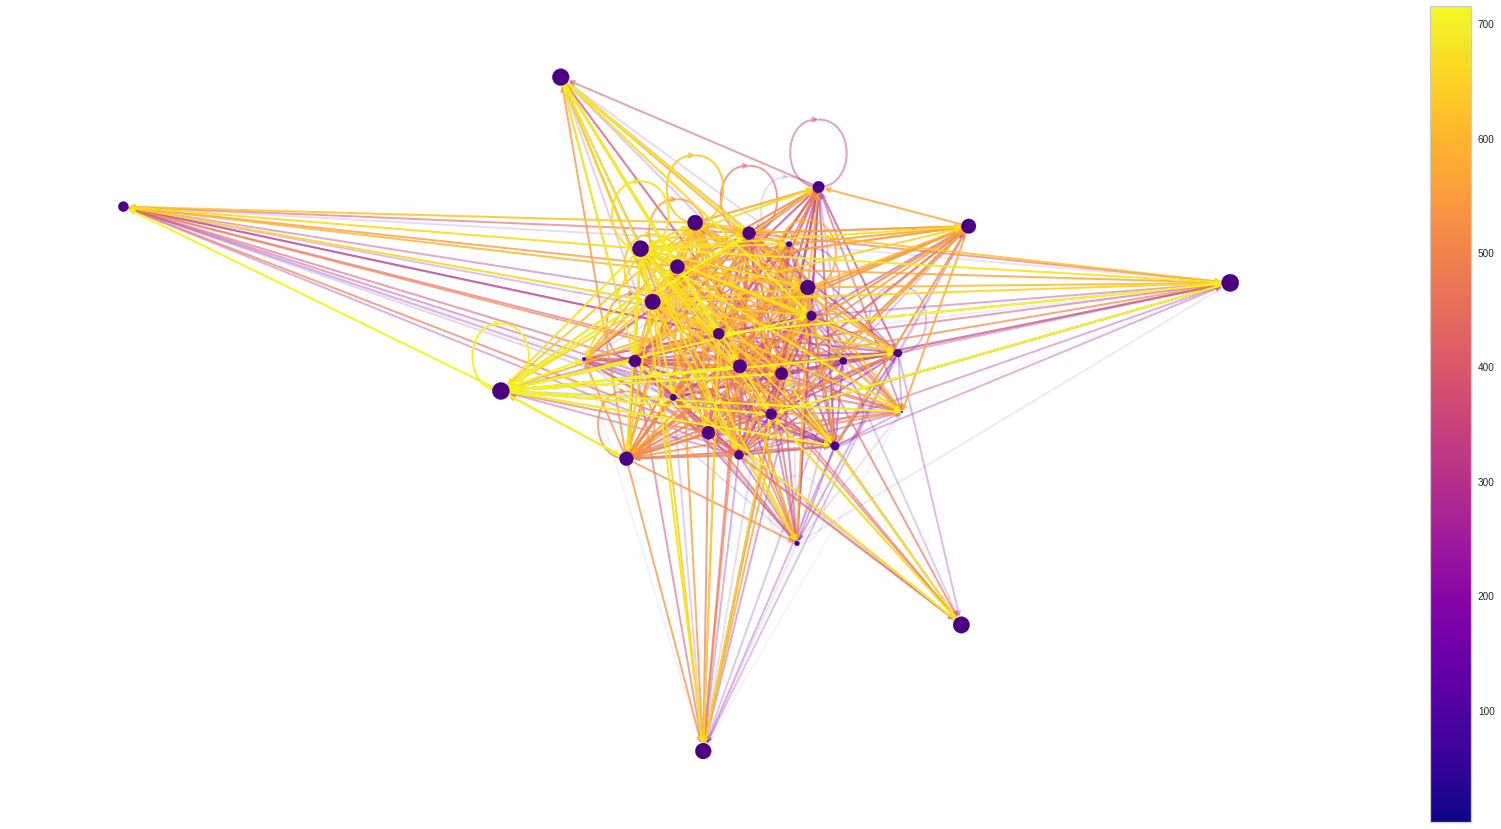

In [315]:
plt.figure(figsize=(30,15))

seed = 13648  # Seed random number generators for reproducibility
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [311]:
sorted(G.in_degree, key=lambda x: x[1], reverse=False)[:3]

[('cerrillos', 3), ('la pintana', 12), ('lo espejo', 20)]

In [312]:
sorted(G.out_degree, key=lambda x: x[1], reverse=False)[:3]

[('lo prado', 1), ('el bosque', 2), ('la granja', 2)]

In [310]:
G.remove_node('estación central')

In [317]:
G2 = G.subgraph(['pudahuel', 'santiago', 'recoleta'])

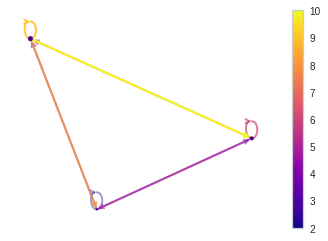

In [319]:
#plt.figure(figsize=(30,15))

seed = 13648  # Seed random number generators for reproducibility
pos = nx.spring_layout(G2, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G2))]
M = G2.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G2, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G2,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()